In [1]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.11.1)


# Coronavirus Modeling

In [0]:
import pandas as pd
import seaborn as sns;
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

We get our data from [here](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv).

The Italy Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile Covid-19 dataset is updated daily.



In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

## Preprocessing and cleaning

Data columns are in Italian. Have to translate them to see what they mean.

In [4]:
data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en'],
      dtype='object')

In [0]:
italian=['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en']
# from Google Translate
english=['date', 'state', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_insulation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'deceased', 'total_cases', 'swabs', 'test_cases', 'note_it',
       'Note_en']

In [0]:
dict = {x[0]:x[1] for x in zip(italian, english)}

In [0]:
data = data.rename(columns=dict)

In [8]:
data.columns

Index(['date', 'state', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_insulation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'deceased', 'total_cases', 'swabs', 'test_cases', 'note_it', 'Note_en'],
      dtype='object')

Let's see if we can make some more features. One important variable is the daily change. I.e., daily new cases, deaths, recovered, etc. 

We already have daily change in positive cases as well as daily new cases. We will construct similar variables for deaths, tests, and recovered.

In [0]:
data['new_deceased'] = data['deceased'].diff()
data['new_swabs'] = data['swabs'].diff()
data['new_healed'] = data['discharged_healed'].diff()
# have new_positives

In [10]:
# format date from string to timestamp
data['date_formatted'] = [pd.to_datetime(d) for d in data['date']]
data['date_formatted'].head

<bound method NDFrame.head of 0    2020-02-24 18:00:00
1    2020-02-25 18:00:00
2    2020-02-26 18:00:00
3    2020-02-27 18:00:00
4    2020-02-28 18:00:00
             ...        
65   2020-04-29 17:00:00
66   2020-04-30 17:00:00
67   2020-05-01 17:00:00
68   2020-05-02 17:00:00
69   2020-05-03 17:00:00
Name: date_formatted, Length: 70, dtype: datetime64[ns]>

We add rolling average to smooth out weekends. We know that weekend tests are lower, which result in a weekly cyclical behavior.

In [0]:
rolling_weekly_average = 7
data['new_positives_rolling'] = data['new_positives'].rolling(window=rolling_weekly_average).mean()
data['new_healed_rolling'] = data['new_healed'].rolling(window=rolling_weekly_average).mean()
data['new_swabs_rolling'] = data['new_swabs'].rolling(window=rolling_weekly_average).mean()
data['new_deceased_rolling'] = data['new_deceased'].rolling(window=rolling_weekly_average).mean()

We categorize intense cases as in intensive care or deceased.

In [0]:
data['intense_cases'] = data['new_deceased'] + data['intensive_care']

## Visualization

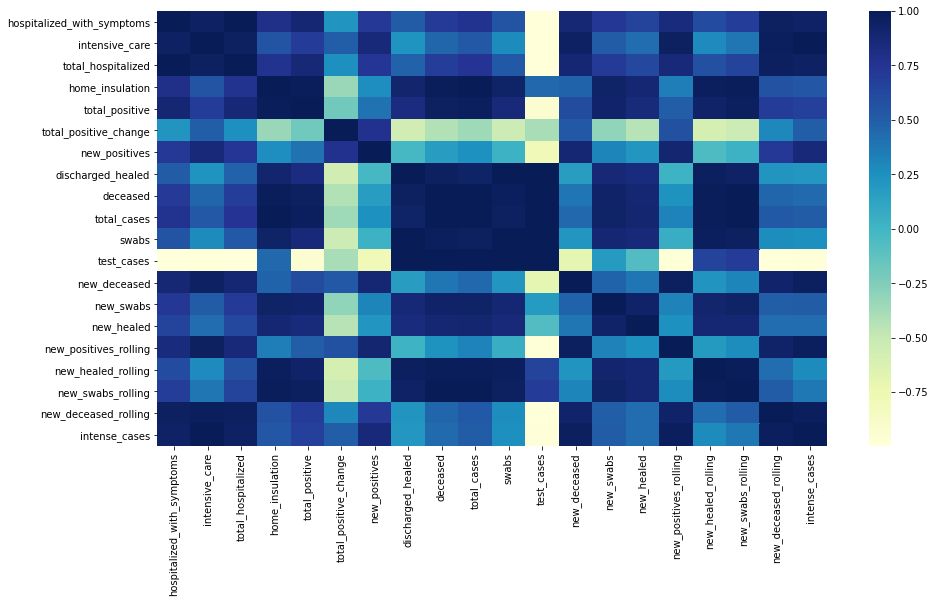

In [13]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(15, 8), facecolor='white')
ax = sns.heatmap(data.corr(), cmap="YlGnBu", ax=ax)

In [0]:
def plotter(col='new_positives', data=data, mark_max=True):
    '''
    Plots column from data

    mark_max: if true, plot vertical line marking when the max value 
    occurs for col
    '''
    fig, ax = plt.subplots(figsize=(12, 9), facecolor='white')
    ax.grid()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 

    # plot data
    ax.scatter(data['date_formatted'], data[col], color='tab:blue')

    ax.set(xlabel='Date', ylabel=col, title='Italy '+col)
    ax.set_facecolor('white')

    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

    if mark_max:
        # find date with max value of col
        date = data.loc[data[col].idxmax()]['date_formatted']
        ax.axvline(date, c="tab:red", zorder=0)
    fig.savefig('italy_'+ col + '.png')
    plt.show()

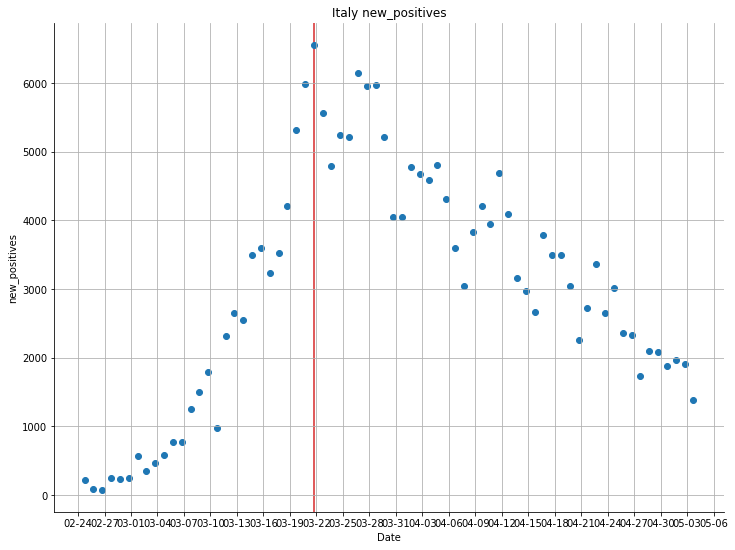

In [15]:
plotter('new_positives')

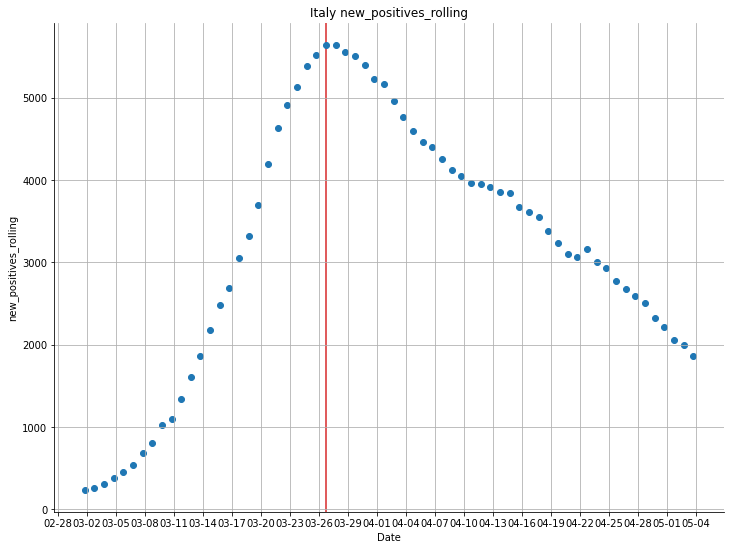

In [16]:
plotter('new_positives_rolling')

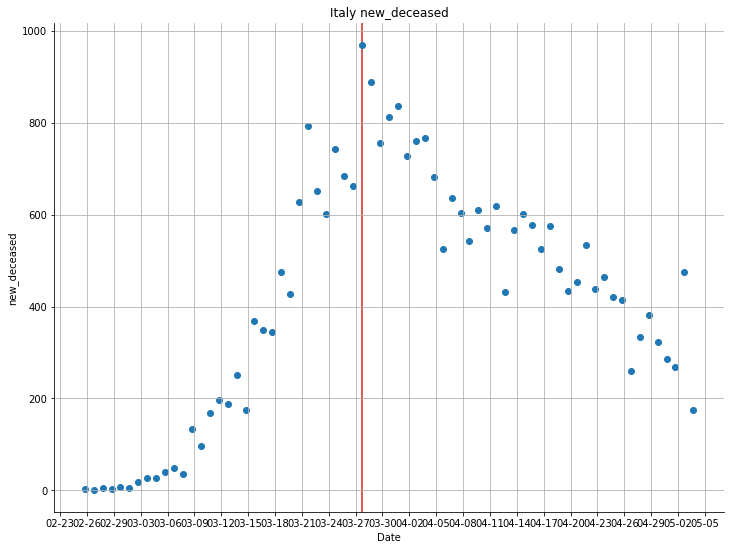

In [17]:
plotter('new_deceased')

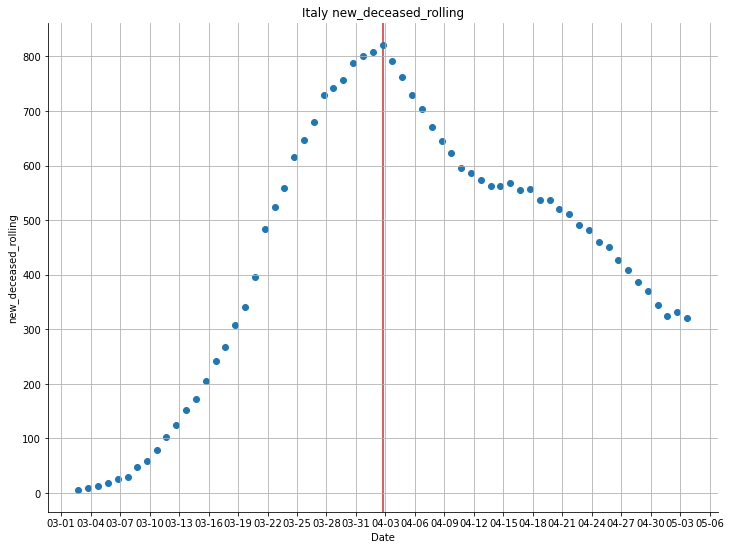

In [18]:
plotter('new_deceased_rolling')

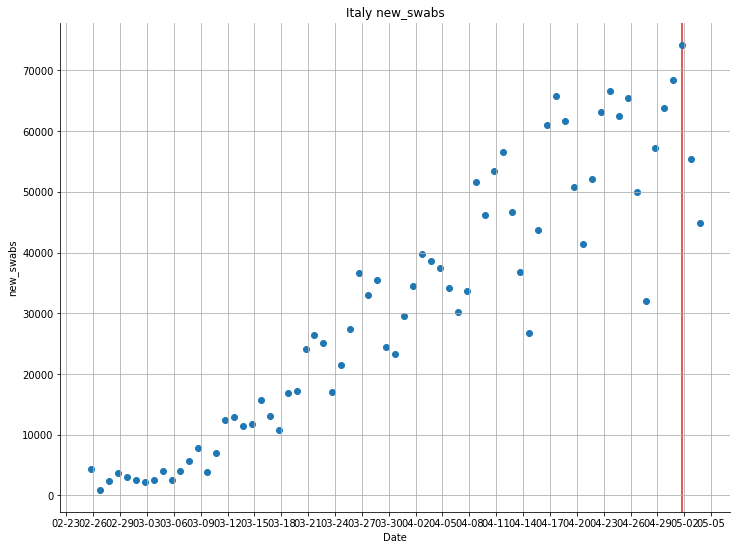

In [19]:
plotter('new_swabs')

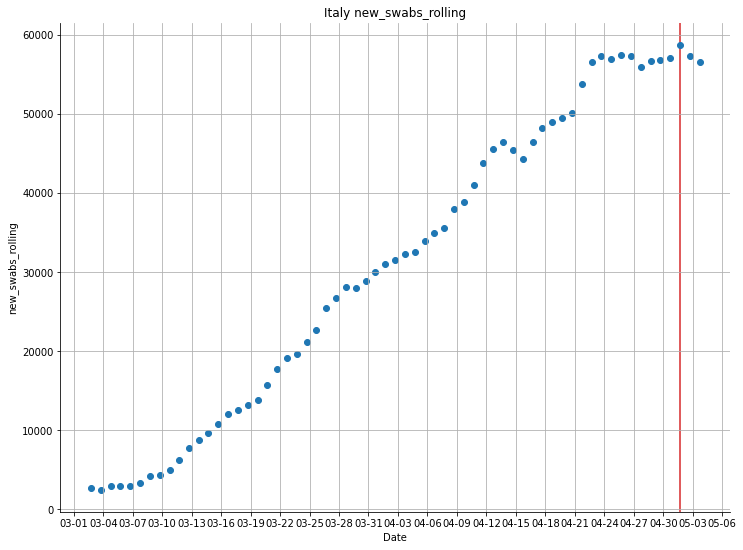

In [20]:
plotter('new_swabs_rolling')

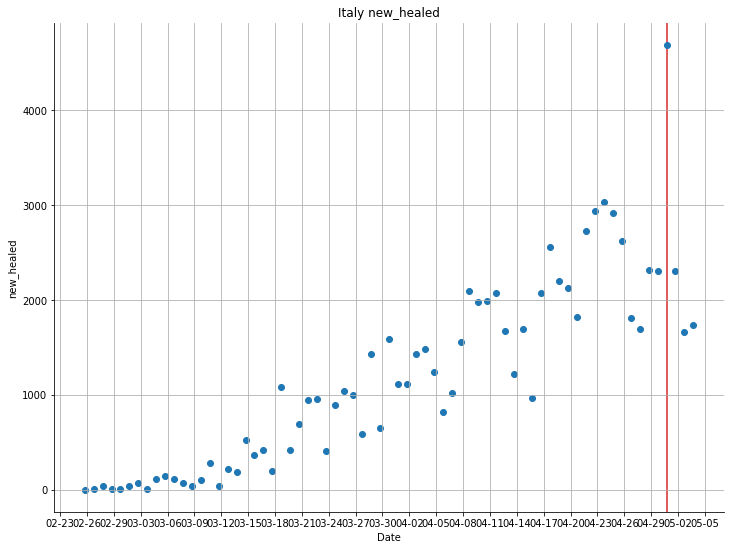

In [21]:
plotter('new_healed')

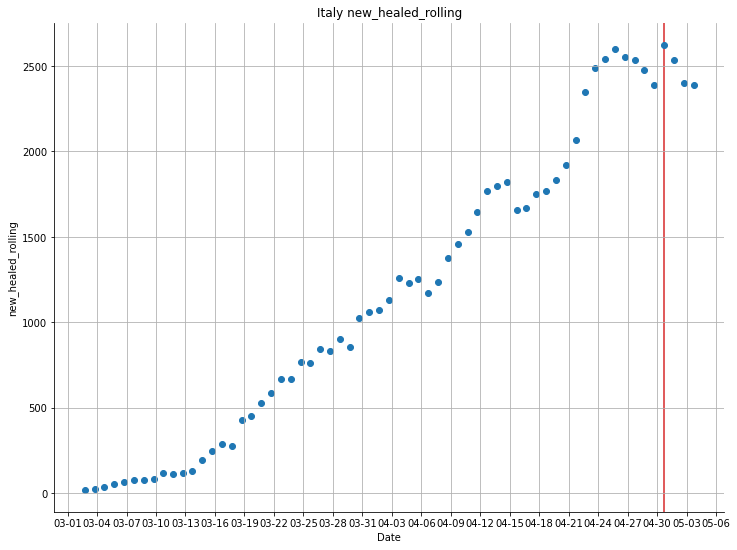

In [22]:
plotter('new_healed_rolling')

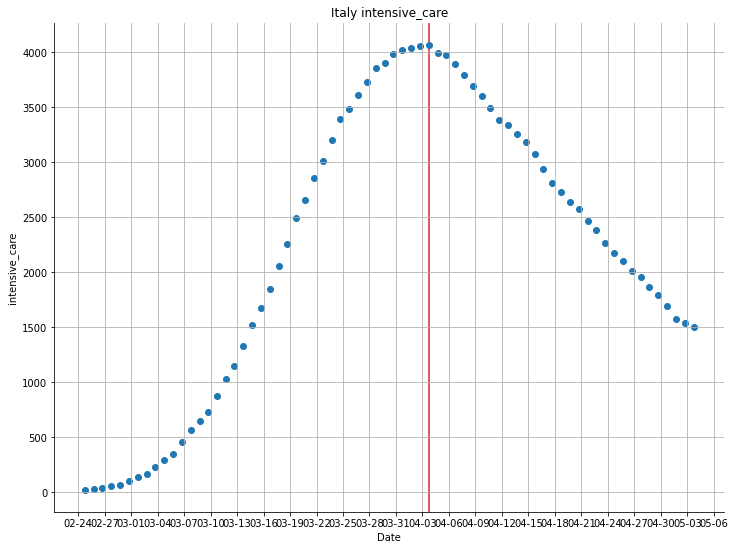

In [23]:
plotter('intensive_care')

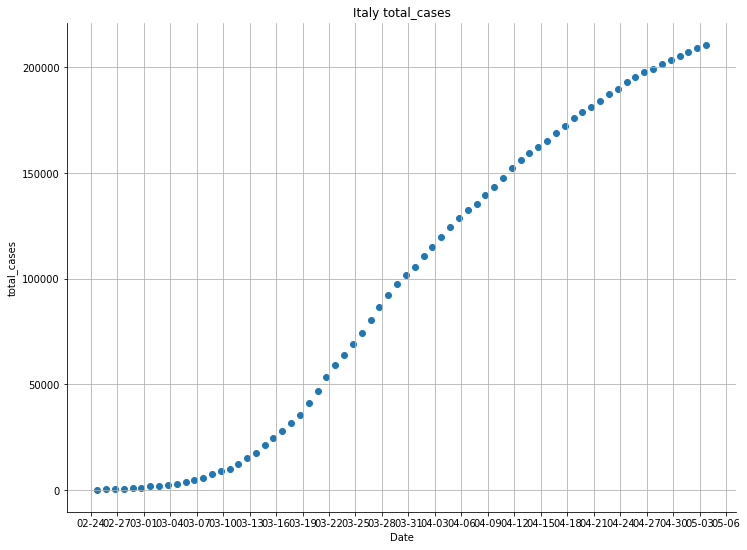

In [24]:
plotter('total_cases',mark_max=False)

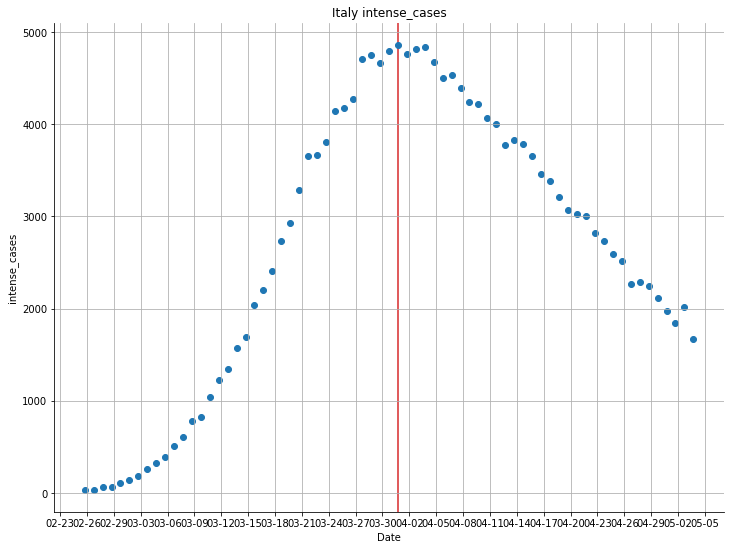

In [25]:
plotter('intense_cases')

Plot percentage to see what the positive rates are.

In [0]:
def percentage_plotter(num_col='new_positives', denom_col='new_swabs', 
                       data=data, mark_max=True):
    '''
    Plots percentage from data calculated as num_col/denom_col * 100

    mark_max: if true, plot vertical line marking when the max value 
    occurs for col
    '''
    perc_d = 100*(data[num_col]/data[denom_col])
    fig, ax = plt.subplots(figsize=(12, 9), facecolor='white')
    ax.grid()
    ax.scatter(data['date_formatted'], perc_d, color='tab:blue')
    ax.set(xlabel='Date',ylabel='percent '+num_col,title='Italy '+'percent '+num_col)
    ax.set_facecolor('white')
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

    if mark_max:
        # find date with max value of col
        date = data.loc[perc_d.idxmax()]['date_formatted']
        ax.axvline(date, c="tab:red", zorder=0)

    fig.savefig('italy_'+'percent '+num_col+'.png')
    plt.show()

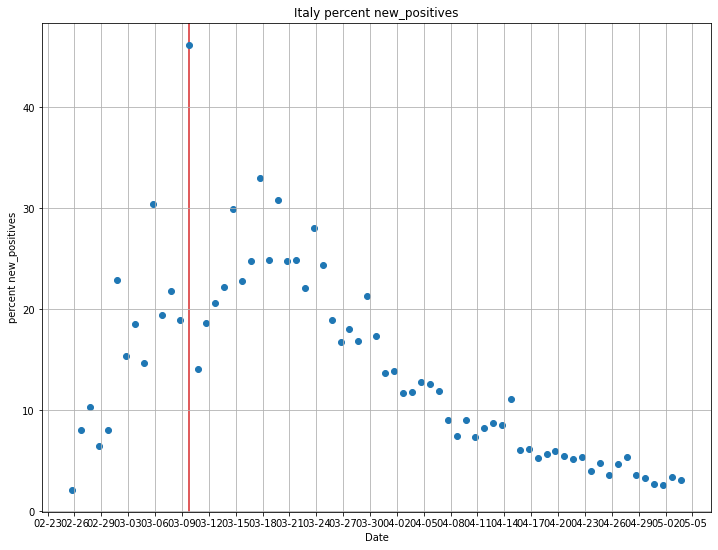

In [96]:
percentage_plotter()

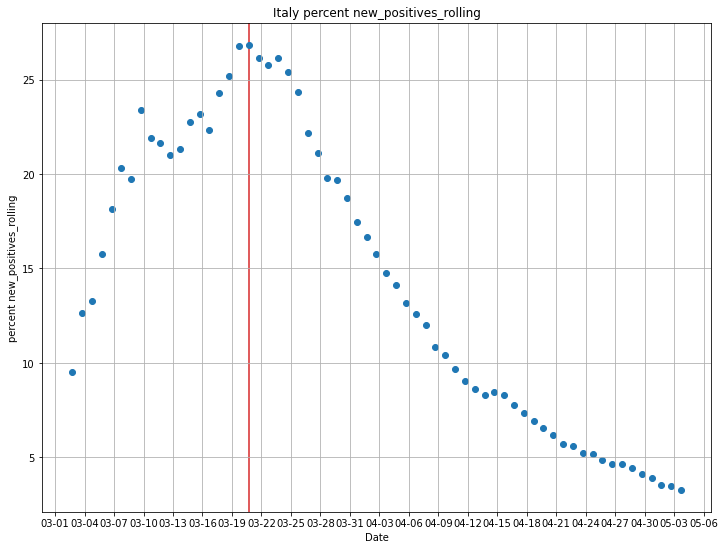

In [97]:
percentage_plotter('new_positives_rolling','new_swabs_rolling')

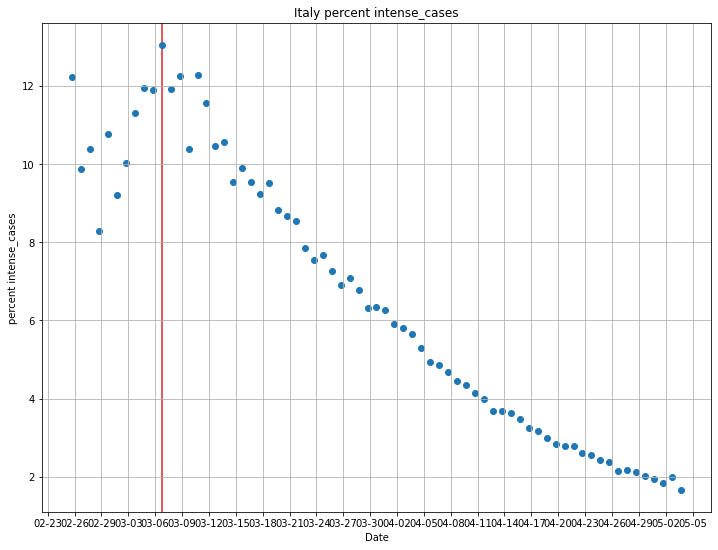

In [98]:
percentage_plotter('intense_cases','total_positive')

## Modeling

We can build our model using supervised learning, using regression models to predict the next `y` variable. 

Since this is a time series data, by repeatedly predicting `y` for the following day, we can have the model give us a sense of the disease progression in the near future. Obviously, as we are refeeding predicted `y` into our model to predict the subsequent value in our time series, the model will get less accurate the further it predicts into the future.

For our `y` target, we will try both `intense_cases` as well as `new_positives`.

### Naive Supervised
Given `X` we predict `y`

Make train test split data. We divide target y column into train and test sets to fit regression.

In [0]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import max_error
import math

In [0]:
# Params
y_col='intense_cases'
train_test_split = 0.7

In [0]:
def get_train_test(perc=0.5, y_col = 'intense_cases'):
    ''' 
    returns train test split of column y_col 
    perc is train data percentage
    '''
    y = data[y_col].fillna(0)
    total_days = len(y)
    x=np.array([i for i in range(len(y))])

    test_proportion = int(perc*total_days)
    x_train, y_train = x[:test_proportion], y[:test_proportion]
    x_test, y_test = x[test_proportion:], y[test_proportion:]

    return x_train.reshape(-1, 1), y_train.values.reshape(-1, 1), x_test.reshape(-1, 1), y_test.values.reshape(-1, 1), test_proportion

In [0]:
x_train, y_train, x_test, y_test, cutoff_idx = get_train_test(perc=0.67, y_col = y_col)

In [0]:
def trainer(model, train_test_split=train_test_split, y_col=y_col):
    '''
    Function to train model using a percentage of observed data and predict the rest
    '''
    x_train, y_train, x_test, y_test, cutoff_idx = get_train_test(perc=0.67, y_col = y_col)
    model.fit(x_train, y_train)
    print("Fitting Complete.\nR Score is: %s" %model.score(x_train, y_train))
    y_pred = model.predict(x_train)
    error = max_error(y_train, y_pred)
    print("max error is %s" %(error))

    y_pred = model.predict(x_test)
    y_pred_max = [y + error for y in y_pred]
    y_pred_min = [y - error for y in y_pred] 

    # plot known data
    plt.grid()
    plt.scatter(data['date_formatted'], data[y_col])

    x_date = data['date_formatted'][cutoff_idx:]

    # plot linear regression prediction
    plt.plot(x_date, y_pred, color='green', linewidth=2)

    # plot error intervals
    plt.plot(x_date, y_pred_max, color='red', linewidth=1, linestyle='dashed')
    plt.plot(x_date, y_pred_min, color='red', linewidth=1, linestyle='dashed')

    plt.xlabel('Date')

    plt.ylabel(y_col)
    plt.savefig(y_col + "_prediction.png")
    plt.show()
    return model, x_train, y_train, x_test, y_test, cutoff_idx

Linear Regression

In [0]:
linreg = linear_model.LinearRegression()

Fitting Complete.
R Score is: 0.9200985113582818
max error is 1310.8769657724333


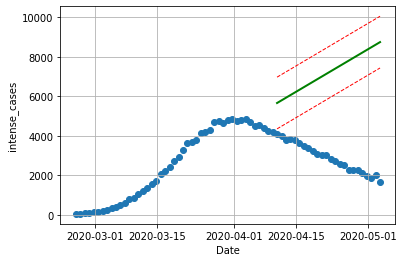

In [36]:
 linreg, x_train, y_train, x_test, y_test, cutoff_idx = trainer(linreg)

In [0]:
params = {'alpha': [10**x for x in range(-10, 2, 1)]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(x_train, y_train)
ridge=Ridge(**ridge_grid.best_params_)

Fitting Complete.
R Score is: 0.9200971150229299
max error is 1307.1557424244456


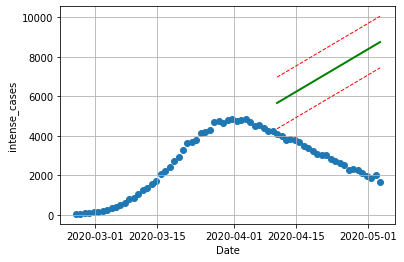

In [38]:
ridge, x_train, y_train, x_test, y_test, cutoff_idx = trainer(ridge)

In [0]:
lasso = Lasso(max_iter=1e6)
params = {'alpha': [10**x for x in range(-5, 1, 1)]}
lasso_grid = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(x_train, y_train)
lasso=Lasso(**lasso_grid.best_params_)

Fitting Complete.
R Score is: 0.9200985097149508
max error is 1310.7493061979658


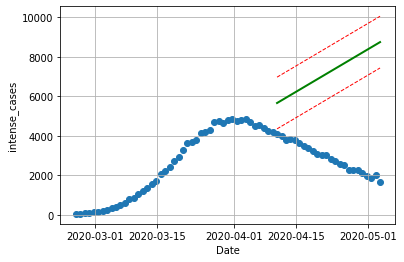

In [40]:
lasso, x_train, y_train, x_test, y_test, cutoff_idx = trainer(lasso)

In [41]:
ratios = [0.1,0.2,0.3,0.4,0.5] + [x/100 for x in range(50, 105, 5)]
elastic_cv = ElasticNetCV(l1_ratio=ratios)
elastic_cv.fit(x_train, y_train)
elastic=ElasticNet(**lasso_grid.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Complete.
R Score is: 0.9200910382498342
max error is 1302.2681876883344


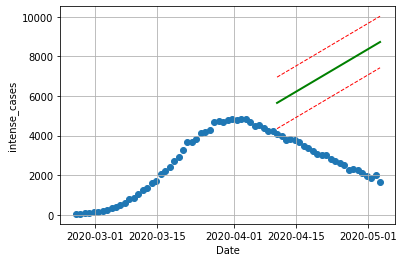

In [42]:
elastic, x_train, y_train, x_test, y_test, cutoff_idx = trainer(elastic)

Not looking very promissing. Lets try random forest.



Random Forest

In [0]:
# Number of trees in random forest
n_estimators = n_estimators = list(range(3,10,1))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(1, 10, 1))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [44]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rf = RandomForestRegressor(**rf_random.best_params_)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.2s


{'n_estimators': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Fitting Complete.
R Score is: 0.9996357121031388
max error is 96.5


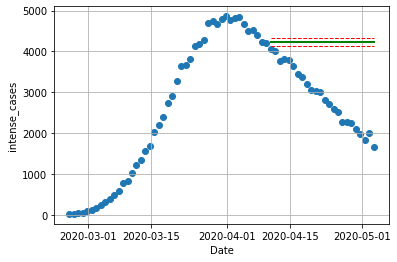

In [45]:
rf, x_train, y_train, x_test, y_test, cutoff_idx = trainer(rf)

It seems to be easily overfit given how sparse the data is. Overall, supervised learning isn't working well. We have to either incorporate more features or factor in autocorrelation. Since the heatmap doesn't show much correlation between features in our dataset, let's go straight to time series models that factor in previous observations when making predictions.

### Time Series Methods
Given past observed `x_i`, we predict next `x_i+1`.

#### Lag and Autocorrelation Plots
Lets confirm that there is enough correlation to justify looking into time series models

Plot lag the which is correlation of observation at time `t` and at `t-1`. 

It looks like a strong positive correlation. From the autocorrelation plot, we don't see much cyclical correlation either. It seems that every observation is strongly positively correlated with the previous observation.

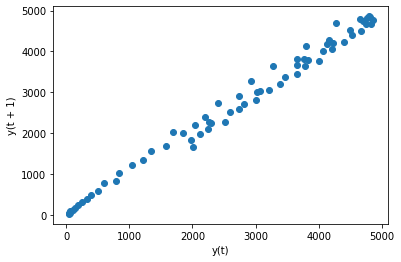

In [46]:
pd.plotting.lag_plot(data[y_col])

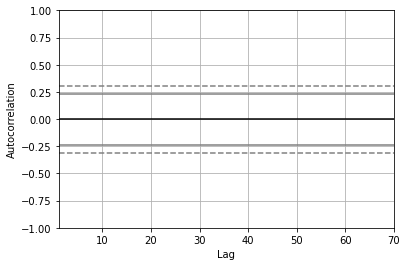

In [47]:
pd.plotting.autocorrelation_plot(data[y_col])

#### Models

[Reference doc](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

In [0]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
x_train, y_train, x_test, y_test, cutoff_idx = get_train_test(perc=0.67, y_col = y_col)

In [0]:
def get_exog_data(exog_col='swabs', cutoff_idx=cutoff_idx):
    '''
    Returns exog_data tuple containing (exog_train, exog_test) bisected at cutoff_idx
    '''
    exog_data = (data[exog_col][:cutoff_idx].values.reshape(-1, 1),data[exog_col][cutoff_idx:].values.reshape(-1, 1))
    return exog_data

In [0]:
def ts_trainer(model, y_train, test_length, cutoff_idx, exog=None, forcast=False):
    '''
    Function to train time series model using a percentage of observed data 
    and predict the rest.
    test_length is number of observations to predict after y_train
    exog is tuple of train and test exogenous data for SARIMAX
    '''

    model = model.fit()

    # stats models is quite buggy -- model predict functions behave differently
    try:
        if exog is None:
            y_pred = model.predict(0, len(y_train)-1)
        else:
            y_pred = model.predict(0, len(y_train)-1, exog=[exog[0]])
        error = max_error(y_train, y_pred)

    except ValueError:
        try:
            if exog is None:
                y_pred = model.predict(0, len(y_train))
            else:
                y_pred = model.predict(0, len(y_train), exog=[exog[0]])
            error = max_error(y_train, y_pred)

        except ValueError:
            # ARIMA model is fickle
            error = 0

    print("max error is %s" %(error))

    if exog is None:
        y_pred = model.predict(len(y_train), len(y_train)+test_length-1)
    else:
        y_pred = model.predict(len(y_train), len(y_train)+test_length-1, 
                               exog=[exog[1]])

    # keep values above 0
    y_pred[y_pred < 0] = 0

    y_pred_max = [y + error for y in y_pred]
    y_pred_min = [y - error for y in y_pred] 

    # plot data
    fig, ax = plt.subplots(figsize=(12, 9), facecolor='white')
    ax.grid()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    # plot existing data
    ax.scatter(data['date_formatted'], data[y_col], color='tab:blue')

    # use existing date time or forecasting future dates
    if 0 < cutoff_idx < len(data['date_formatted']):
        x_date = data['date_formatted'][cutoff_idx:]
    else: 
        # generate the next n days, n=test_length
        last_date = data['date_formatted'][len(data['date_formatted'])-1]
        x_date = [last_date + timedelta(days=i) for i in range(test_length)]
        x_date = np.array(x_date)

    # plot predicted values
    ax.plot(x_date, y_pred, color='white' if forcast else 'tab:green', linewidth=2)

    # plot error intervals
    if forcast:
        ax.fill_between(x_date, y_pred_max,  
                 y_pred_min, color="#3F5D7D") 
        # if reaches zero, mark on plot with vertical line
        min_index = np.where(y_pred == 0)[0]
        if len(min_index) > 0:
            date = x_date[min_index[0]]
            ax.axvline(date, c='tab:green')
    else:
        ax.plot(x_date, y_pred_max, color='tab:red', linewidth=1, linestyle='dashed')
        ax.plot(x_date, y_pred_min, color='tab:red', linewidth=1, linestyle='dashed')

    plt.title("Italy " + y_col, fontsize=22)
    plt.xlabel('Date', fontsize=16)

    plt.ylabel(y_col, fontsize=16)
    plt.savefig(y_col + "_ts_prediction.png")
    plt.show()
    return model

max error is 128.00525723742464


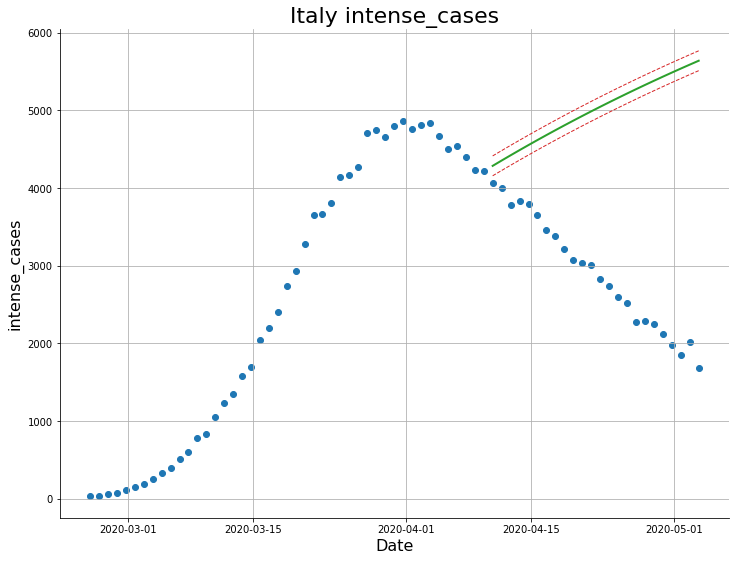

In [81]:
autoreg = AutoReg(y_train, lags=1)
autoreg = ts_trainer(autoreg, y_train, len(y_test), cutoff_idx)

max error is 2494.3182509590292


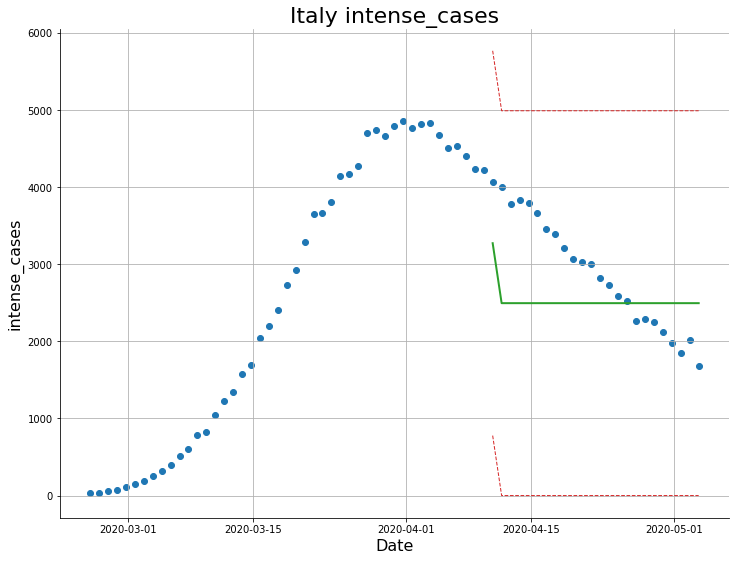

In [82]:
ma = ARMA(y_train, order=(0, 1))
ma = ts_trainer(ma, y_train, len(y_test), cutoff_idx)

max error is 2134.606519065148


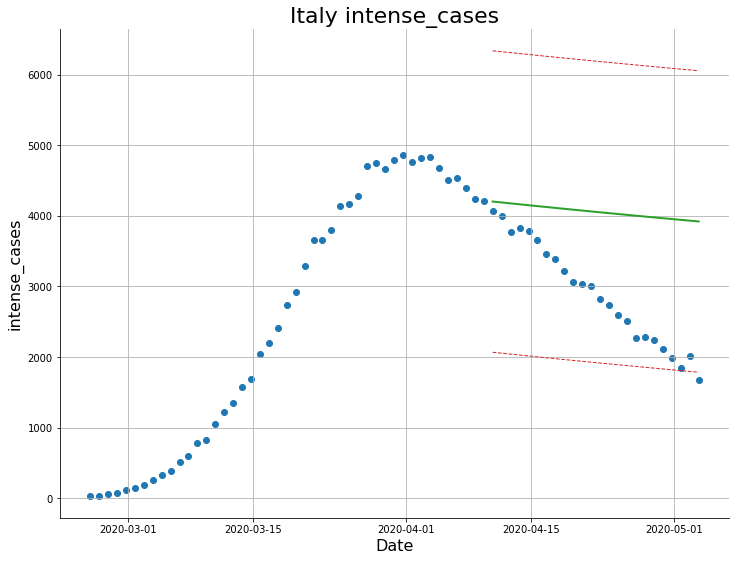

In [83]:
arma = ARMA(y_train, order=(1, 1))
arma = ts_trainer(arma, y_train, len(y_test), cutoff_idx)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


max error is 1987.0781377282233


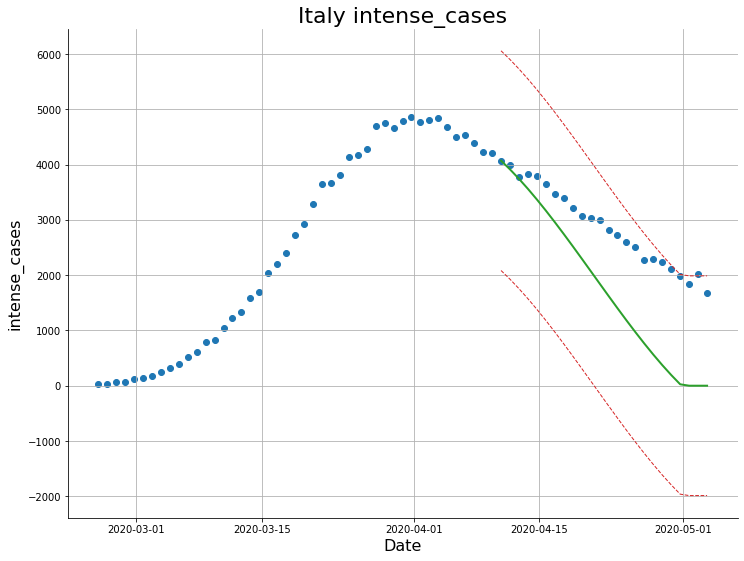

In [84]:
arma = ARMA(y_train, order=(2, 1))
arma = ts_trainer(arma, y_train, len(y_test), cutoff_idx)

max error is 0


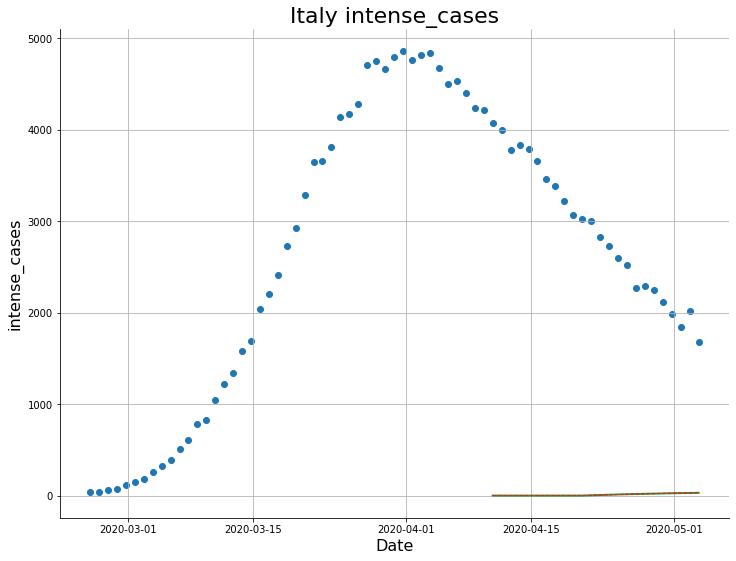

In [85]:
arima = ARIMA(y_train, order=(1, 1, 1))
arima = ts_trainer(arima, y_train, len(y_test), cutoff_idx)

max error is 0


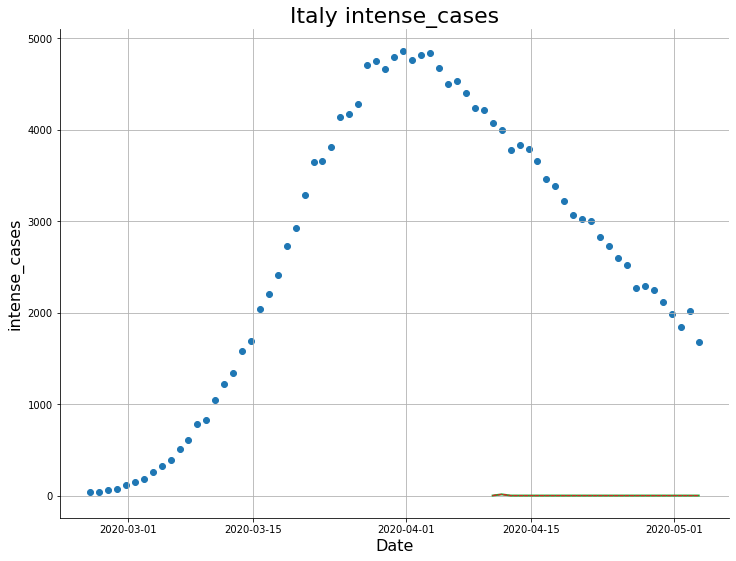

In [86]:
arima = ARIMA(y_train, order=(1, 2, 1))
arima = ts_trainer(arima, y_train, len(y_test), cutoff_idx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


max error is 343.93975173903164


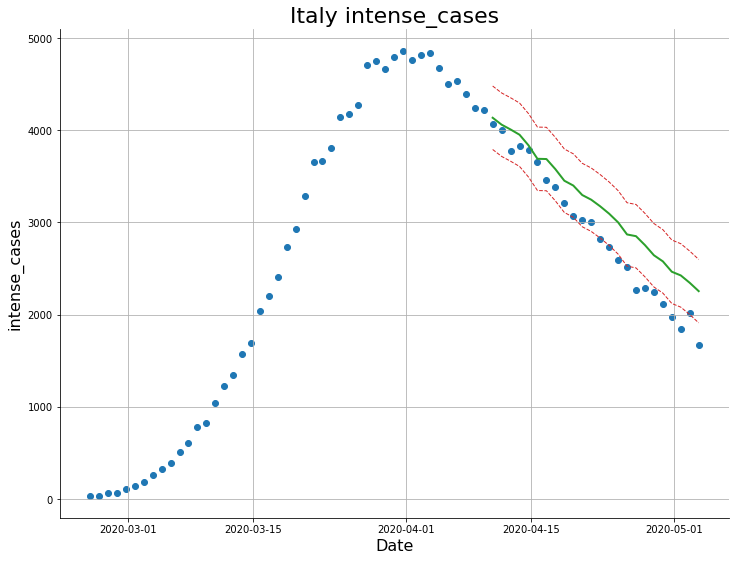

In [87]:
sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))
sarima = ts_trainer(sarima, y_train, len(y_test), cutoff_idx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


max error is 348.31278465416653


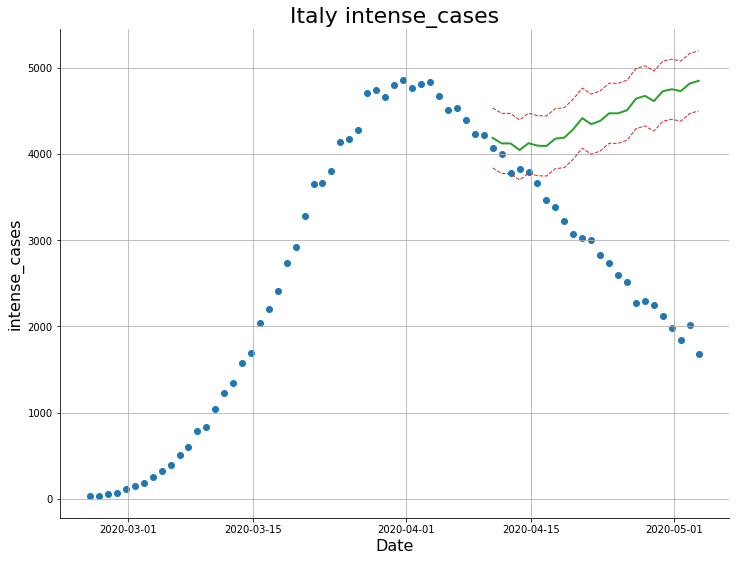

In [88]:
sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 15))
sarima = ts_trainer(sarima, y_train, len(y_test), cutoff_idx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


max error is 298.138797977168


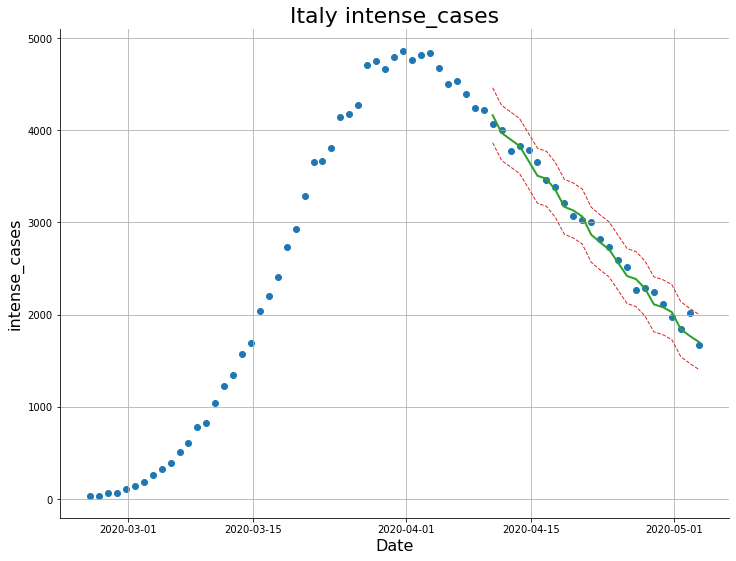

In [89]:
sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
sarima = ts_trainer(sarima, y_train, len(y_test), cutoff_idx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


max error is 382.6267488539106


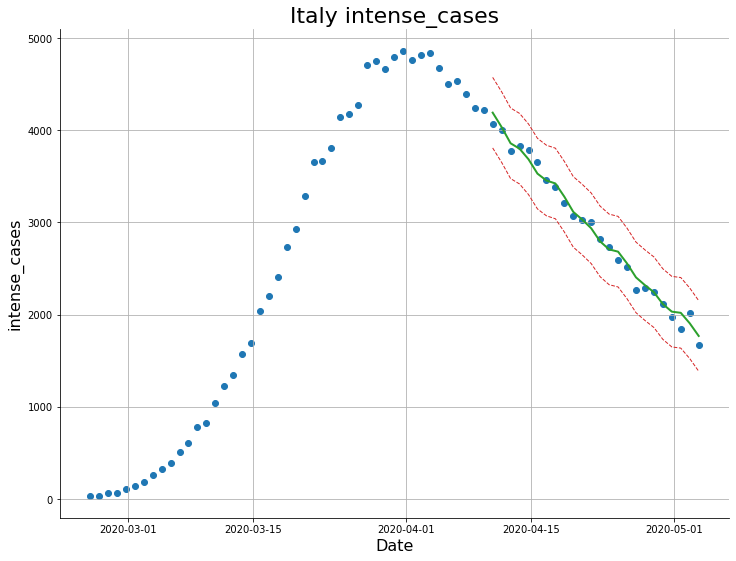

In [90]:
sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima = ts_trainer(sarima, y_train, len(y_test), cutoff_idx)

max error is 292.1664831463322


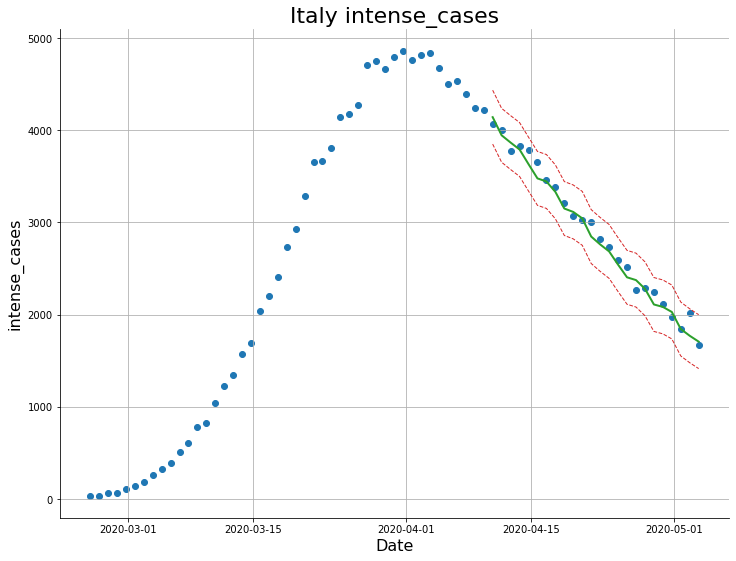

In [91]:
sarima = SARIMAX(y_train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 10))
sarima = ts_trainer(sarima, y_train, len(y_test), cutoff_idx)

The SARIMA model seems to be fitting the trend well when incorporating 10 day seasonal cycles. Strangely, weekly cycles are worse fits.

Next, let us try adding an exogenous variable to see what happens

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


max error is 371.3995746325363


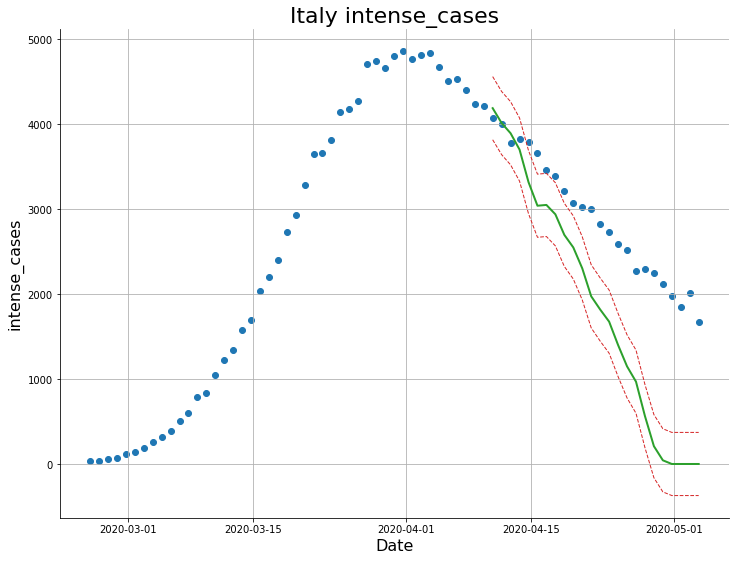

In [92]:
exog_data = get_exog_data('swabs')
sarimax = SARIMAX(y_train, exog=exog_data[0], order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
sarimax = ts_trainer(sarimax, y_train, len(y_test), cutoff_idx, exog=exog_data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


max error is 311.4601056930678


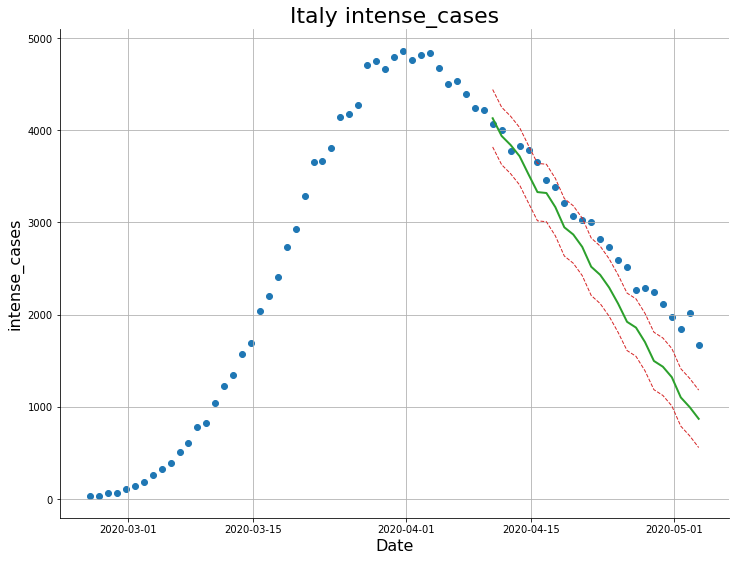

In [93]:
exog_data = get_exog_data('new_positives')
sarimax = SARIMAX(y_train, exog=exog_data[0], order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
sarimax = ts_trainer(sarimax, y_train, len(y_test), cutoff_idx, exog=exog_data)

As expected, the fit is worse, since the data features are either endogenous (don't include new information not contained in `y`) or don't correlate strongly.

Let's use the SARIMA model to predict the next 20 days.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


max error is 311.1969505996876


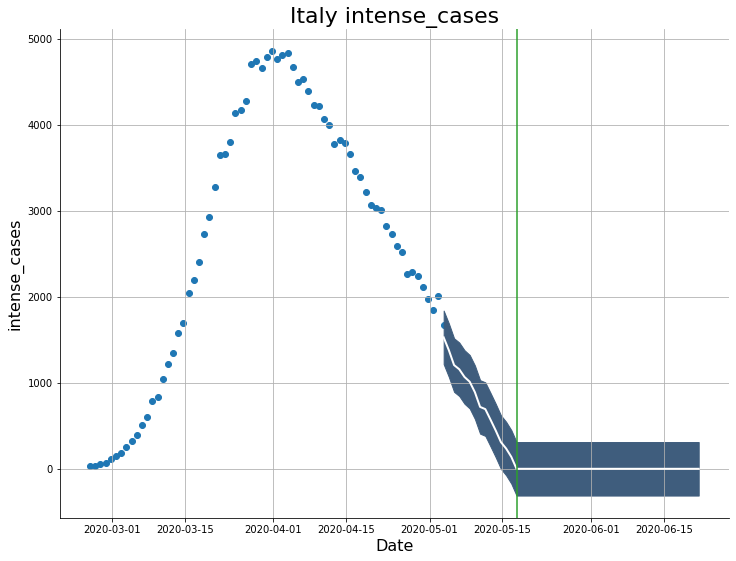

In [94]:
forcast_next=50
y_total=np.concatenate([y_train, y_test])
sarima = SARIMAX(y_total, order=(1, 1, 1), seasonal_order=(1, 1, 2, 10))
sarima = ts_trainer(sarima, y_total, test_length=forcast_next, cutoff_idx=-1, forcast=True)